In [1]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import hdbscan

%matplotlib inline

In [117]:
from sklearn.neighbors import VALID_METRICS
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [3]:
final_df = pd.read_csv("../data/processed/final_df.csv")

In [4]:
final_df.head()

,id_student,age_band,gender,highest_education,n_assignments,mean_score,final_result,total_clicks,studied_credits,region,code_module,code_presentation,press_mod
0,11391,55<=,M,HE Qualification,5,82.0,Pass,934,240,East Anglian Region,AAA,2013J,2013J-AAA
1,28400,35-55,F,HE Qualification,5,66.4,Pass,1435,60,Scotland,AAA,2013J,2013J-AAA
2,31604,35-55,F,A Level or Equivalent,5,76.0,Pass,2158,60,South East Region,AAA,2013J,2013J-AAA
3,32885,0-35,F,Lower Than A Level,5,54.4,Pass,1034,60,West Midlands Region,AAA,2013J,2013J-AAA
4,38053,35-55,M,A Level or Equivalent,5,68.0,Pass,2445,60,Wales,AAA,2013J,2013J-AAA


In [42]:
#find null values
#final_df[final_df.isnull().any(axis=1)]

,age_band,gender,highest_education,n_assignments,mean_score,final_result,total_clicks,studied_credits,region,code_module,code_presentation,press_mod,clicks_per_asmt
id_student,,,,,,,,,,,,,


In [6]:
#final_df.describe()

In [7]:
#replace nan with mean value
final_df["mean_score"].fillna(72.83, inplace = True)

In [8]:
#replace "0s" with mean
final_df['n_assignments'] = np.where((final_df.n_assignments == 0), 7, final_df.n_assignments)

In [9]:
final_df['clicks_per_asmt'] = final_df['total_clicks']/final_df['n_assignments']

In [10]:
final_df

,id_student,age_band,gender,highest_education,n_assignments,mean_score,final_result,total_clicks,studied_credits,region,code_module,code_presentation,press_mod,clicks_per_asmt
0,11391,55<=,M,HE Qualification,5,82.000000,Pass,934,240,East Anglian Region,AAA,2013J,2013J-AAA,186.800000
1,28400,35-55,F,HE Qualification,5,66.400000,Pass,1435,60,Scotland,AAA,2013J,2013J-AAA,287.000000
2,31604,35-55,F,A Level or Equivalent,5,76.000000,Pass,2158,60,South East Region,AAA,2013J,2013J-AAA,431.600000
3,32885,0-35,F,Lower Than A Level,5,54.400000,Pass,1034,60,West Midlands Region,AAA,2013J,2013J-AAA,206.800000
4,38053,35-55,M,A Level or Equivalent,5,68.000000,Pass,2445,60,Wales,AAA,2013J,2013J-AAA,489.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26716,2620947,0-35,F,A Level or Equivalent,9,88.888889,Distinction,476,30,Scotland,GGG,2014J,2014J-GGG,52.888889
26717,2645731,35-55,F,Lower Than A Level,9,88.111111,Distinction,893,30,East Anglian Region,GGG,2014J,2014J-GGG,99.222222
26718,2648187,0-35,F,A Level or Equivalent,9,76.666667,Pass,312,30,South Region,GGG,2014J,2014J-GGG,34.666667
26719,2679821,35-55,F,Lower Than A Level,2,91.500000,Withdrawn,275,30,South East Region,GGG,2014J,2014J-GGG,137.500000


In [11]:
#final_df.columns

In [12]:
final_df.set_index(['id_student'], inplace=True)

In [13]:
##def drop_col (df, list):
#    df.drop(columns=(list), inplace=True)
#    return df

In [14]:
#col_drop = ["press_mod", "code_presentation",]

In [15]:
#drop_col (final_df, col_drop)

In [16]:
final_df['final_result'] = final_df['final_result'].apply(lambda x: str(x).replace('Distinction','4'))
final_df['final_result'] = final_df['final_result'].apply(lambda x: str(x).replace('Pass','3'))
final_df['final_result'] = final_df['final_result'].apply(lambda x: str(x).replace('Fail','2'))
final_df['final_result'] = final_df['final_result'].apply(lambda x: str(x).replace('Withdrawn','1'))

In [17]:
clustering_df = pd.DataFrame(data=final_df, columns=["n_assignments","mean_score", "clicks_per_asmt", "studied_credits","final_result"])

## Scaling num feat + result

In [18]:

FEATS = ['n_assignments', 'mean_score', 'clicks_per_asmt', 'studied_credits',
        'final_result']

In [19]:
transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), 
                ('scaler', StandardScaler())])

In [20]:
preprocessor = \
ColumnTransformer(transformers=[('num', transformer, FEATS)])

In [21]:
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                             

In [22]:
clustering_1 = pd.DataFrame(data=preprocessor.fit_transform(final_df))

# UMAP 1 (Standard Scaler)

In [23]:
clustering_1 = clustering_1.to_numpy()

In [24]:
reducer_1 = umap.UMAP(random_state=42)
reducer_1.fit(clustering_1.data)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [25]:
embedding_1 = reducer_1.transform(clustering_1.data)

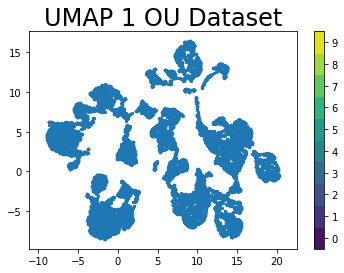

In [26]:
plt.scatter(embedding_1[:, 0], embedding_1[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP 1 OU Dataset', fontsize=24);

# DBSCAN 1

In [134]:
clustering_1 = DBSCAN(min_samples=5, eps=0.75, metric='euclidean' ).fit(embedding_1)

clustering_1

DBSCAN(algorithm='auto', eps=0.75, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

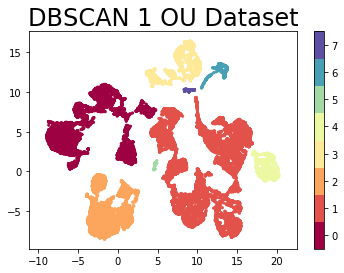

In [135]:
plt.scatter(embedding_1[:, 0], embedding_1[:, 1], c=clustering_1.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(clustering_1.labels_))+1)-0.5).set_ticks(np.arange(len(np.unique(clustering_1.labels_))))
plt.title('DBSCAN 1 OU Dataset', fontsize=24);

# HDBSCAN 1

In [114]:

clusterer_1 = hdbscan.HDBSCAN(min_cluster_size=20, )

clusterer_1.fit(embedding_1)

clusterer_1

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=False)

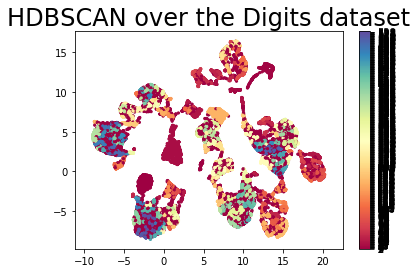

In [113]:
plt.scatter(embedding_1[:, 0], embedding_1[:, 1], c=clusterer_1.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(clusterer_1.labels_)))+0.5).set_ticks(np.arange(len(np.unique(clusterer_1.labels_))))
plt.title('HDBSCAN over the Digits dataset', fontsize=24);

In [60]:
final_df['cluster_1']=clustering_1.labels_

# UMAP 2 (log)

In [39]:
clustering_df.dtypes

n_assignments        int64
mean_score         float64
clicks_per_asmt    float64
studied_credits      int64
final_result         int64
dtype: object

In [35]:
#clustering_df = clustering_df.astype(int)
clustering_df = clustering_df.astype({'final_result': int})

In [38]:
clustering_df= clustering_df.round(2)

In [46]:
clustering_df['mean_score'] = np.where((clustering_df.mean_score == 0.0), 72.83, clustering_df.mean_score)

In [50]:
clustering_df[clustering_df.isin(['0'])].stack() 

Series([], dtype: float64)

In [51]:
clustering_df_log = np.log(clustering_df)

In [52]:
clustering_2 = clustering_df_log.to_numpy()

In [53]:
reducer_2 = umap.UMAP(random_state=42)
reducer_2.fit(clustering_2.data)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [54]:
embedding_2 = reducer_2.transform(clustering_2.data)

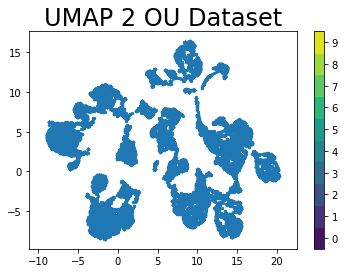

In [56]:
plt.scatter(embedding_1[:, 0], embedding_1[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP 2 OU Dataset', fontsize=24);

# DBSCAN 2

In [106]:
clustering_2 = DBSCAN(min_samples=5, eps=0.5, algorithm='kd_tree').fit(embedding_1)

clustering_2

DBSCAN(algorithm='kd_tree', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

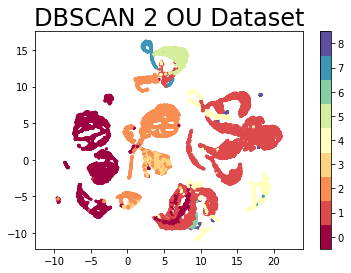

In [107]:
plt.scatter(embedding_2[:, 0], embedding_2[:, 1], c=clustering_2.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(clustering_2.labels_))+1)-0.5).set_ticks(np.arange(len(np.unique(clustering_2.labels_))))
plt.title('DBSCAN 2 OU Dataset', fontsize=24);

In [59]:
final_df['cluster_2']=clustering_2.labels_

In [61]:
final_df

,age_band,gender,highest_education,n_assignments,mean_score,final_result,total_clicks,studied_credits,region,code_module,code_presentation,press_mod,clicks_per_asmt,cluster_2,cluster_1
id_student,,,,,,,,,,,,,,,
11391,55<=,M,HE Qualification,5,82.000000,3,934,240,East Anglian Region,AAA,2013J,2013J-AAA,186.800000,0,0
28400,35-55,F,HE Qualification,5,66.400000,3,1435,60,Scotland,AAA,2013J,2013J-AAA,287.000000,1,1
31604,35-55,F,A Level or Equivalent,5,76.000000,3,2158,60,South East Region,AAA,2013J,2013J-AAA,431.600000,1,1
32885,0-35,F,Lower Than A Level,5,54.400000,3,1034,60,West Midlands Region,AAA,2013J,2013J-AAA,206.800000,1,1
38053,35-55,M,A Level or Equivalent,5,68.000000,3,2445,60,Wales,AAA,2013J,2013J-AAA,489.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620947,0-35,F,A Level or Equivalent,9,88.888889,4,476,30,Scotland,GGG,2014J,2014J-GGG,52.888889,7,7
2645731,35-55,F,Lower Than A Level,9,88.111111,4,893,30,East Anglian Region,GGG,2014J,2014J-GGG,99.222222,7,7
2648187,0-35,F,A Level or Equivalent,9,76.666667,3,312,30,South Region,GGG,2014J,2014J-GGG,34.666667,5,5
